# SPINNA sample notebook
This notebook illustrates how to use SPINNA's API, focusing on the exemplary EGFR data which can be found under: https://github.com/jungmannlab/picasso/tree/master/tests/data/SPINNA

In [ ]:
from picasso import io, spinna
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# USER PARAMETERS
PIXELSIZE = 130 # camera pixel size, nm
LABEL_UNC = 6.0 # label position uncertainty, nm
LE = 0.375 # labeling efficiency, 37.5%
ROI = 10_000 # simulated region of interest, nm
GRANULARITY = 34
N_SIM = 100 # number of simulations for each SPINNA fitting round
N_REPEATS = 15 # number of bootstrap rounds

In [3]:
# load experimental data
path_egfr = "egfr_mols.hdf5" # change if needed
egfr_mols, info = io.load_locs(path_egfr)
egfr_coords = np.stack([egfr_mols["x"], egfr_mols["y"]], axis=1) * PIXELSIZE
n_egfr = int(egfr_coords.shape[0] / LE)

In [4]:
# define structures: monomer, dimer, tetramer
monomer = spinna.SingleStructure(title="Monomer")
monomer.define_coordinates(target="EGFR", x=[0], y=[0], z=[0])
dimer = spinna.SingleStructure(title="Dimer")
dimer.define_coordinates(target="EGFR", x=[-10.5, 10.5], y=[0, 0], z=[0, 0])
tetramer = spinna.SingleStructure(title="Tetramer")
tetramer.define_coordinates(target="EGFR", x=[-31.5, -10.5, 10.5, 31.5], y=[0, 0, 0, 0], z=[0, 0, 0, 0])
structures = [monomer, dimer, tetramer]

In [5]:
print(dimer)

Type: SingleStructure, Title: Dimer
Coordinates below: x, y, z (nm)

EGFR:
-10.5, 0, 0
10.5, 0, 0



In [6]:
# set up the mixer object which is used for simulating the structures
mixer = spinna.StructureMixer(
    structures=structures,
    label_unc={"EGFR": LABEL_UNC},
    le={"EGFR": LE},
    width=ROI, height=ROI,
)

In [7]:
# generate parameter search space - tested stoichiometries
search_space = spinna.generate_N_structures(
    structures=structures,
    N_total={"EGFR": n_egfr},
    granularity=GRANULARITY,
)
# search space contains the numbers of structures to simulate for each 
# tested stoichiometry
index = 101
example_n_structures = [
    search_space["Monomer"][index], 
    search_space["Dimer"][index], 
    search_space["Tetramer"][index],
]
print(f"Example number of structures (m/d/t): {example_n_structures}")
print(f"And the corresponding proportions: {mixer.convert_counts_to_props(example_n_structures)}")

Example number of structures (m/d/t): [9570, 512, 170]
And the corresponding proportions: [84.89  9.08  6.03]


In [8]:
# set up the object for SPINNA fitting
fitter = spinna.NNDFitter(
    mixer=mixer,
    gt_coords={"EGFR": egfr_coords},
    N_sim=N_SIM,
)

In [9]:
# run SPINNA fitting
best_N_structures, best_score = fitter.fit_N_structures(
    N_structures=search_space,
    save="", # change to a path to save a .csv file with the scores for each stoichiometry tested
    asynch=True, # multiprocessing
    callback="console", # display progress here
)

Fitting structures:  99%|█████████▉| 589/595 [02:34<00:01,  3.81it/s]


In [10]:
print(f"Best numbers of structures (m/d/t): {best_N_structures}")
print(f"Corresponding proportions: {mixer.convert_counts_to_props(best_N_structures)}")

Best numbers of structures (m/d/t): [6836  683  769]
Corresponding proportions: [60.619995 12.11     27.27    ]


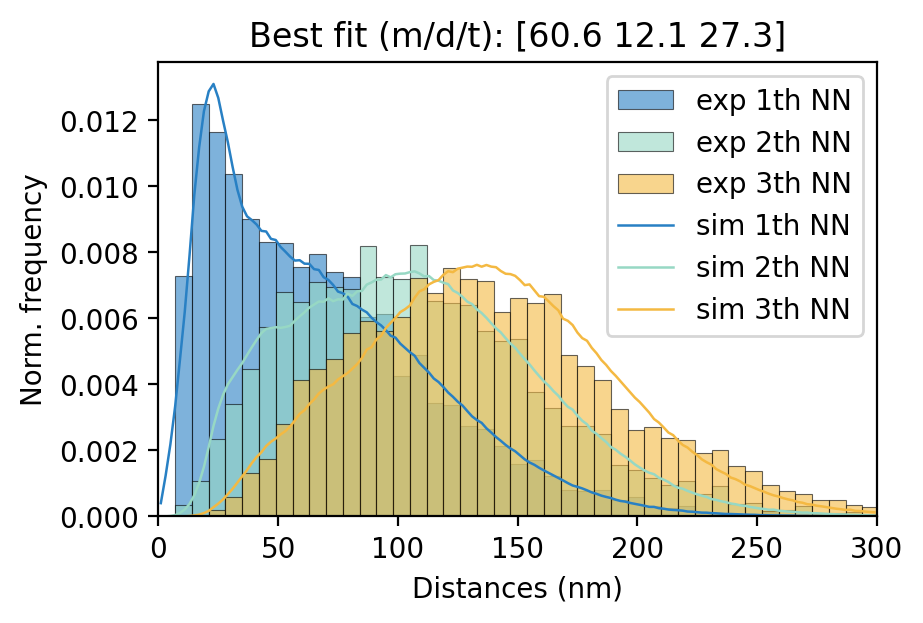

In [11]:
# plot the resulting (nearest neighbor distances) NND histograms

# first extract simulated NND
dists_sim = spinna.get_NN_dist_simulated(
    N_str=best_N_structures,
    N_sim=N_SIM*10,
    mixer=mixer,
)[0]
fig, ax = spinna.plot_NN(
    data1=egfr_coords, data2=egfr_coords, n_neighbors=3, 
    figsize=(4.5, 3),
    mode="hist", binsize=7, xlim=(0, 300), return_fig=True,    
) # experimental data
spinna.plot_NN(
    dist=dists_sim,
    mode="plot", binsize=2, xlim=(0, 300), 
    title=f"Best fit (m/d/t): {mixer.convert_counts_to_props(best_N_structures).round(1)}",
    show_legend=True,
    fig=fig, ax=ax, alpha=1,
)
plt.show()

In [12]:
# lastly, let's look at the fit uncertainty - we use bootstrapping
np.random.seed(42)
res_props = []
for j in range(N_REPEATS):
    print(f"Bootstrap round {j+1}/{N_REPEATS}")
    # generate new "experimental" data
    new_gt_coords = mixer.run_simulation(N_structures=best_N_structures)["EGFR"]
    # run SPINNA on the new data
    new_n_str, _ = fitter.fit_N_structures(
        N_structures=search_space,
        asynch=True,
        callback="console",
    )
    res_props.append(mixer.convert_counts_to_props(new_n_str))

means = np.mean(res_props, axis=0)
stds = np.std(res_props, axis=0)
print(f"Mean stoichiometry (m/d/t): {means.round(1)}")
print(f"Uncertainty (std) in stoichiometry (m/d/t): {stds.round(1)}")

Bootstrap round 1/15


Fitting structures:  99%|█████████▉| 589/595 [02:31<00:01,  3.88it/s]

Bootstrap round 2/15



Fitting structures:  98%|█████████▊| 583/595 [02:28<00:03,  3.93it/s]

Bootstrap round 3/15



Fitting structures:  98%|█████████▊| 583/595 [02:22<00:02,  4.08it/s]

Bootstrap round 4/15



Fitting structures:  99%|█████████▉| 589/595 [02:18<00:01,  4.24it/s]

Bootstrap round 5/15



Fitting structures:  99%|█████████▉| 589/595 [02:23<00:01,  4.09it/s]

Bootstrap round 6/15



Fitting structures:  99%|█████████▉| 589/595 [02:25<00:01,  4.04it/s]

Bootstrap round 7/15



Fitting structures:  99%|█████████▉| 589/595 [02:23<00:01,  4.10it/s]

Bootstrap round 8/15



Fitting structures:  98%|█████████▊| 583/595 [02:34<00:03,  3.78it/s]

Bootstrap round 9/15



Fitting structures:  99%|█████████▉| 589/595 [02:20<00:01,  4.20it/s]


Bootstrap round 10/15


Fitting structures:  98%|█████████▊| 583/595 [02:29<00:03,  3.90it/s]

Bootstrap round 11/15



Fitting structures:  98%|█████████▊| 583/595 [02:35<00:03,  3.74it/s]

Bootstrap round 12/15



Fitting structures:  99%|█████████▉| 589/595 [02:59<00:01,  3.27it/s]

Bootstrap round 13/15



Fitting structures:  99%|█████████▉| 589/595 [03:09<00:01,  3.12it/s]

Bootstrap round 14/15



Fitting structures:  99%|█████████▉| 589/595 [03:00<00:01,  3.27it/s]

Bootstrap round 15/15



Fitting structures:  99%|█████████▉| 589/595 [02:51<00:01,  3.44it/s]

Mean stoichiometry (m/d/t): [60.6 11.9 27.5]
Uncertainty (std) in stoichiometry (m/d/t): [2.2 4.2 2.1]
